# Smoke_Pollution Estimates (ODell v. EPA_API)


# License
The code in this notebook was developed by Sue Boyd in support of the Course Project Assignment in DATA 512, a course in the UW MS Data Science degree program. The code in this notebook is provided under the MIT license located in the same repository as this notebook.

# Chat GPT Attribution
Selected functions or codeblocks in this Notebook were created with assistance from Chat GPT (https://chat.openai.com/). For any function or codeblock that was created with assistance from Chat GPT, the impacted code is isolated in a function or procedure and the use of Chat GPT is noted. Information on the prompts used to query Chat GPT isprovided at the end of the file. 

# Step 0: Prepare Notebook 

In [1]:
# import needed libraries 

import pandas as pd
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats

# Step 1: Load and Prep Data 

In [2]:
#Load ODell Data 

fp = "Data/Annual Summary PM25 Data ODell.csv"
pm25 = pd.read_csv(fp)
pm25.head()

,Year,Mean PM25 Smoke Days,Mean PM25 Non-Smoke Days,Diff in Mean PM25,Num Smoke Days,Avg. Annual Delta_PM25,Annual Mean Combined
0,2006,9.962489,9.129669,0.832820,25.0,0.057042,9.186712
1,2007,11.532424,10.237317,1.295107,30.0,0.106447,10.343764
2,2008,13.020036,10.141664,2.878372,40.0,0.315438,10.456240
3,2009,8.738054,7.630536,1.107518,18.0,0.054617,7.685154
4,2010,6.578359,7.080457,-0.502098,17.0,-0.023385,7.057071


In [3]:
# define a constant we'll need later 
DATA_YEARS = pm25["Year"].drop_duplicates().tolist()
DATA_YEARS

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

Load the EPA API data, drop unneeded columns, add indicator column

In [4]:
# load data from EPA, API  - not kriged
f = "Data/epa_api_pm25.csv"
pm25_api  = pd.read_csv(f)

In [5]:
# drop unneeded columns 
col_to_keep = pm25_api.columns.drop(['Local Site Name', 'Site Address', 'State',
       'County', 'City', 'Units of Measure', 'Method',
       'Sample Duration', 'Observation Count'])

pm25_api = pm25_api[col_to_keep]
pm25_api.head()

,Date,Parameter Name,Arithmetic Mean,AQI,Month,Month Number,Year
0,1999-03-07,PM2.5 - Local Conditions,20.2,68.0,March,3,1999
1,1999-03-13,PM2.5 - Local Conditions,12.8,52.0,March,3,1999
2,1999-03-16,PM2.5 - Local Conditions,34.0,97.0,March,3,1999
3,1999-03-25,PM2.5 - Local Conditions,9.8,41.0,March,3,1999
4,1999-03-28,PM2.5 - Local Conditions,4.7,20.0,March,3,1999


In [6]:
# Add an indicator for fire season to pm25_api
all_months = pm25_api["Month"].drop_duplicates().to_list()
fire_season_months = all_months[4:10]
pm25_api["Fire_Season"] = pm25_api["Month"].isin(fire_season_months)
pm25_api.head()

,Date,Parameter Name,Arithmetic Mean,AQI,Month,Month Number,Year,Fire_Season
0,1999-03-07,PM2.5 - Local Conditions,20.2,68.0,March,3,1999,False
1,1999-03-13,PM2.5 - Local Conditions,12.8,52.0,March,3,1999,False
2,1999-03-16,PM2.5 - Local Conditions,34.0,97.0,March,3,1999,False
3,1999-03-25,PM2.5 - Local Conditions,9.8,41.0,March,3,1999,False
4,1999-03-28,PM2.5 - Local Conditions,4.7,20.0,March,3,1999,False


# Step 2: Compare ODell PM Estimates and EPA API Data Estimates 

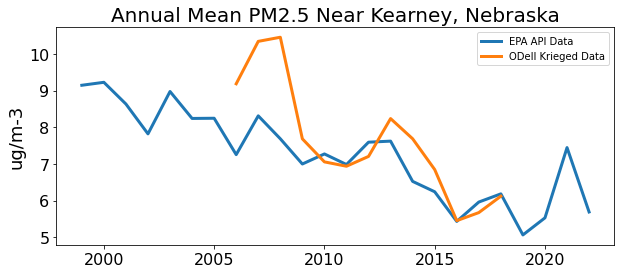

In [17]:
# Let's compare Annual Mean PM2.5 Near Kearney O'Dell Data vs. EPA API Data 
grouped_pm25_api = pm25_api.groupby(['Year'])["Arithmetic Mean"].mean().reset_index()

x_api = grouped_pm25_api["Year"]
y0_api = grouped_pm25_api["Arithmetic Mean"]
x = pm25["Year"]
y0 = pm25["Annual Mean Combined"]

# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x_api, y0_api, label = "EPA API Data", linewidth= 3)
ax.plot(x, y0, label = "ODell Krieged Data", linewidth = 3)
#plt.xlabel("Year")
plt.ylabel("ug/m-3", fontsize = 18)
plt.title("Annual Mean PM2.5 Near Kearney, Nebraska", fontsize=20)
plt.legend();
#max_y_value = max(y0)*1.2
#ax.set_ylim(0, max_y_value)
plt.xticks(fontsize = 16)  # Rotate the tick labels for better visibility
plt.yticks(fontsize = 16)

plt.show();


Krieged Data a good match to the EPA API Data, although some differences in early years 2005-2008

In [25]:
# calculate correlation coefficient between EPA and O'Dell Estimates 

df = grouped_pm25_api.iloc[7:20]
y0_api_slim = df["Arithmetic Mean"]
np.corrcoef(y0_api_slim, y0)[0, 1]





0.8368921043095753

In [8]:
# also inspect max pm25 by year 
max = pm25_api.groupby(['Year'])["Arithmetic Mean"].max().reset_index()
max.head()

,Year,Arithmetic Mean
0,1999,34.0
1,2000,39.9
2,2001,35.8
3,2002,27.6
4,2003,31.0


Now let's inspect if there is a way to estimate fire related impacts using EPA api data in years when O'Dell Data is not available

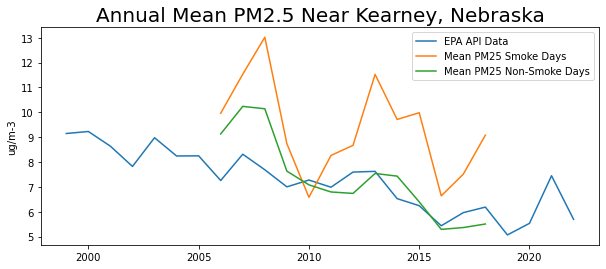

In [9]:
# Replace O'Dell overall mean with smoke and non-smoke mean in above graph

# EPA api data 
x_api = grouped_pm25_api["Year"]
y0_api = grouped_pm25_api["Arithmetic Mean"]


#O'Dell data 
x = pm25["Year"]
y1 = pm25["Mean PM25 Smoke Days"]
y2 = pm25["Mean PM25 Non-Smoke Days"]

# Create plot 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x_api, y0_api, label = "EPA API Data")
ax.plot(x, y1, label = "Mean PM25 Smoke Days")
ax.plot(x, y2, label = "Mean PM25 Non-Smoke Days")
#plt.xlabel("Year")
plt.ylabel("ug/m-3")
plt.title("Annual Mean PM2.5 Near Kearney, Nebraska", fontsize=20)
plt.legend()
#max_y_value = max(y0)*1.2
#ax.set_ylim(0, max_y_value)

In [10]:
# What if we take the max API reading for each month in fire season, minus the annual average
# as a rough look at how "bad" the bad days are 






